# EAD Model

* EAD (exposure at default): the amount of the exposure at the moment the borrower default

* EAD = total funded amount x credit conversation factor

In [13]:
#import libraries 
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score

In [9]:
#load_data
loan_data_inputs_train = pd.read_csv('loan_data_inputs_train.csv', index_col = 0)

## 1. Data Preprocessing
Similar as for LGD model 

In [10]:
loan_data_defaults = loan_data_inputs_train[loan_data_inputs_train['loan_status'].isin(['Charged Off',
                                                                                       'Does not meet the credit policy. Status:Charged Off'])]
loan_data_defaults['mths_since_last_delinq'].fillna(0,inplace = True)
loan_data_defaults['mths_since_last_record'].fillna(0,inplace = True)
loan_data_defaults['pub_rec'].fillna(0,inplace = True)

### 1.1 Dependent Variable
For EAD, we set depdent variable to be CCF (credit conversion factor)

* CCF: the proportion of the original amount of the loan that is still outstanding at the moment when the borrower defaulted

* CCF = (funded_amount - total rocovered)/funded_amount

In [11]:
loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt']-loan_data_defaults['total_rec_prncp'])/loan_data_defaults['funded_amnt']
loan_data_defaults['CCF'].describe()

count    34619.000000
mean         0.735853
std          0.200476
min          0.000438
25%          0.631644
50%          0.789502
75%          0.888383
max          1.000000
Name: CCF, dtype: float64

(array([  17.,   50.,   23.,   77.,   53.,   60.,  111.,   58.,   95.,
         150.,  123.,  156.,  166.,  181.,  190.,  227.,  244.,  266.,
         273.,  290.,  333.,  346.,  410.,  404.,  469.,  471.,  487.,
         589.,  622.,  656.,  671.,  755.,  774.,  934.,  973., 1128.,
        1159., 1248., 1377., 1460., 1614., 1710., 1707., 1891., 1954.,
        2136., 1890., 1721., 1226.,  694.]),
 array([4.3800000e-04, 2.0429240e-02, 4.0420480e-02, 6.0411720e-02,
        8.0402960e-02, 1.0039420e-01, 1.2038544e-01, 1.4037668e-01,
        1.6036792e-01, 1.8035916e-01, 2.0035040e-01, 2.2034164e-01,
        2.4033288e-01, 2.6032412e-01, 2.8031536e-01, 3.0030660e-01,
        3.2029784e-01, 3.4028908e-01, 3.6028032e-01, 3.8027156e-01,
        4.0026280e-01, 4.2025404e-01, 4.4024528e-01, 4.6023652e-01,
        4.8022776e-01, 5.0021900e-01, 5.2021024e-01, 5.4020148e-01,
        5.6019272e-01, 5.8018396e-01, 6.0017520e-01, 6.2016644e-01,
        6.4015768e-01, 6.6014892e-01, 6.8014016e-01, 7.0

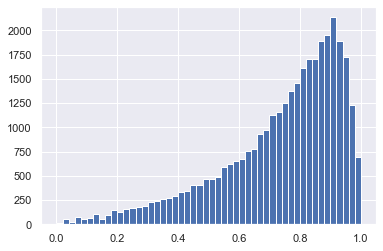

In [12]:
plt.hist(loan_data_defaults['CCF'],50)

The shape suggests that we can use only on a simple linear regression model 

# EAD Model
## Estimation and interpretion

In [31]:
#train test split
ead_inputs_train, ead_inputs_test, ead_targets_train, ead_targets_test = train_test_split(loan_data_defaults.drop(['CCF'],axis=1),loan_data_defaults['CCF'],test_size = 0.2,random_state = 42)

In [19]:
#a list of features in consideration
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim']

# list of reference categories
features_reference_cat = ['grade:G', 'home_ownership:RENT', 'verification_status:Verified','purpose:credit_card','initial_list_status:f']

In [20]:
#pre-process training data
ead_inputs_train = ead_inputs_train[features_all].drop(features_reference_cat, axis = 1)

In [24]:
#create linear regression model
reg_ead = linear_model.LinearRegression()
#train the model
reg_ead.fit(ead_inputs_train,ead_targets_train)

LinearRegression()

In [27]:
#create a summary table
feature_name = ead_inputs_train.columns.values
summary_table = pd.DataFrame(columns = ['Feature name'],data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_ead.coef_)
summary_table.index = summary_table.index+1
summary_table.loc[0] = ['Intercept',reg_ead.intercept_]
summary_table = summary_table.sort_index()
summary_table

,Feature name,Coefficients
0,Intercept,1.097832e+00
1,grade:A,-2.792011e-01
2,grade:B,-2.205590e-01
3,grade:C,-1.606139e-01
4,grade:D,-1.107421e-01
5,grade:E,-6.101409e-02
6,grade:F,-1.369878e-02
7,home_ownership:MORTGAGE,-6.355679e-03
8,home_ownership:NONE,6.607550e-02
9,home_ownership:OTHER,-1.431148e-02


* Positive coefficients = Increase in the CCF (higher risk)
* Negative coefficients = Decrease in the CCF (lower risk)

For example, customers with external grade:A has a 28% lower CCF than those with grade:G 

## Model Validation

In [32]:
# testset data preparation
ead_inputs_test = ead_inputs_test[features_all].drop(features_reference_cat, axis = 1)

In [35]:
# predict use reg_ead.predict
y_hat_test_ead = reg_ead.predict(ead_inputs_test)

# calculate correlation
ead_targets_test_temp = ead_targets_test.reset_index(drop = True)
pd.concat([ead_targets_test_temp, pd.DataFrame(y_hat_test_ead)],axis = 1).corr()

,CCF,0
CCF,1.000000,0.525112
0,0.525112,1.000000


We see a correlation at 0.525 which is okay. We shall also look at the distribution of the residuals 
(i.e. the differences between actual and predicted values)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='CCF', ylabel='Density'>

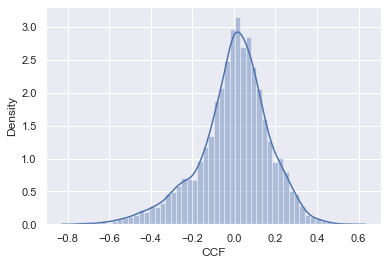

In [37]:
sns.distplot(ead_targets_test - y_hat_test_ead)

We see an approximate normal distribution centred at zero.
The models predictive power is relatively good and seems to be a good model methodologically. 

In [39]:
pd.DataFrame(y_hat_test_ead).describe()
y

,0
count,6924.000000
mean,0.737209
std,0.103432
min,0.343746
25%,0.663478
50%,0.735183
75%,0.810235
max,1.012680


In [ ]:
The minimum predictive value is 0.34, which is ok/